In [1]:
import sys
sys.path.insert(0, '../')
from bandits.linucb import TFLinUCB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Installing GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.executing_eagerly()


True

# Data reading and buffers creation

In [4]:
def read_data():
    items_features = pd.read_csv('../processed_data/item_features.csv')
    items_meta = pd.read_csv('../processed_data/meta_features.csv')
    users_ratings = pd.read_csv('../../../movilens/rating.csv')
    return items_features, items_meta, users_ratings

In [5]:
items_features, items_meta, users_ratings = read_data()

In [6]:
items = items_meta['movieId'].values

In [7]:
users_ratings = users_ratings[users_ratings['rating']>=3.5]

In [8]:
users_ratings['rating'] = 1

In [9]:
grouped_ratings = users_ratings.groupby('userId')['movieId'].apply(list).apply(len)>1

In [10]:
grouped_ratings.value_counts()

True     138248
False       114
Name: movieId, dtype: int64

In [11]:
grouped_ratings = grouped_ratings.to_frame()
users_to_use = grouped_ratings[grouped_ratings['movieId']==True].reset_index()['userId'].values

In [12]:
users_ratings = users_ratings[users_ratings['userId'].isin(users_to_use)]

In [13]:
users_ratings['timestamp'] = pd.to_datetime(users_ratings['timestamp'])
users_ratings.sort_values(by='timestamp', inplace=True)

In [14]:
users_ratings = users_ratings.reset_index().drop(columns='index')

In [15]:
users_ratings.head(2)

,userId,movieId,rating,timestamp
0,28507,1176,1,1995-01-09 11:46:44
1,131160,47,1,1995-01-09 11:46:49


In [16]:
items_features.head(2)

,movieId,Action,Adult,Adventure,Animation,Biography,Children,Comedy,Crime,Documentary,...,unknown,1891-1916,1916-1941,1941-1966,1966-1991,1991-2016,movie,short,tv,video
0,1,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [17]:
items_meta.head(2)

,Unnamed: 0,movieId,title,genres,tags,imdbId,primaryName,titleType,isAdult,startYear,averageRating,numVotes,counts
0,0,1,Toy Story (1995),"['Children', 'Adventure', 'Comedy', 'Animation...","['3d', 'action', 'adventure', 'affectionate', ...",tt0114709,"['Tim Allen', 'John Ratzenberger', 'Wallace Sh...",movie,0,1991-2016,8.3,872273,49695.0
1,1,2,Jumanji (1995),"['Children', 'Adventure', 'Comedy', 'Family', ...","['action', 'adventure', 'animal movie', 'anima...",tt0113497,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",movie,0,1991-2016,7.0,302198,22243.0


In [18]:
items_meta['startYear'].value_counts()

1991-2016    16809
1966-1991     5754
1941-1966     3231
1916-1941     1419
1891-1916       65
Name: startYear, dtype: int64

In [19]:
items_meta['genres'] = items_meta['genres'].apply(lambda x: json.loads(x.replace("'",'"')))

In [20]:
class UserHistBuffer:
    def __init__(self, n_max=10):
        self.user_dict = {}
        self.n_max = n_max
    
    def add(self, user_id, item_id):
        user_history = self.user_dict.get(user_id, [])
        user_history.append(item_id)
        if not user_history:
            self.user_dict.update({user_id:user_history})
        else:
            user_history = user_history[-self.n_max:]
            self.user_dict.update({user_id:user_history})
    def get(self, user_id, default=[]):
        return self.user_dict.get(user_id, default)

In [21]:
from sklearn.base import TransformerMixin

class FrequencyTransformer(TransformerMixin):
    def __init__(self, scale=False, classes=None):
        self.scale = scale
        self.classes_ = classes
        self.fitted = False

    def fit(self, X):
        if self.classes_ is None:
            self.classes_ = np.unique(np.hstack(X))
        self.fitted = True
        return self

    def to_numpy(self, arr):
        if isinstance(arr[0], list):
            arr = [np.array(i) for i in arr]

    def transform(self, X):
        assert self.fitted, 'You should use fit before using transform.'
        self.to_numpy(X)
        count_table = np.zeros(shape=(len(X), len(self.classes_)), dtype='float16')
        lens = [len(i) for i in X]
        maxlen = max(lens)
        broadcasted = np.full((len(X), maxlen), dtype='object', fill_value='unk')
        mask = np.arange(maxlen) < np.array(lens)[:, None]
        broadcasted[mask] = np.concatenate(X)
        for idx, class_ in enumerate(self.classes_):
            count_table[:, idx] = (broadcasted == class_).sum(axis=1)
        if self.scale:
            count_table = count_table / count_table.sum(axis=1).reshape(-1, 1)
            count_table[~np.isfinite(count_table)] = 0
        return count_table


In [22]:
class UserFeatureBuffer:
    def __init__(self, items_meta, items_column, feature_order, feature_shape=None):
        self.items_meta = items_meta
        self.items_column = items_column
        self.feature_columns = feature_order
        self.feature_shape = feature_shape
        self.unique_in_cols = {}
        for column in self.feature_columns:
            try:
                self.unique_in_cols.update({column:self.items_meta[column].unique()})
            except:
                self.unique_in_cols.update({column:np.unique(np.hstack(items_meta[column].values))})
        
    def transform(self, user_history, return_names=False, scale=True):
        user_history = np.array(user_history)
        if user_history.size!=0:
            subset = items_meta[items_meta[self.items_column].isin(user_history)]
            result = np.array([])
            names = np.array([])
            for column in self.feature_columns:
                classes = self.unique_in_cols.get(column)
                to_transform = np.hstack(subset[column].values).reshape(1, -1)
                transformer = FrequencyTransformer(classes=classes, scale=scale)
                tmp_result = transformer.fit_transform(to_transform)
                result = np.append(result, tmp_result)
                names = np.append(names, classes)
            if return_names:
                return result, names
            else:
                return result
        elif self.feature_shape:
            return np.zeros(shape=(self.feature_shape,))
        else:
            return []

In [47]:
len(users_ratings)

12195452

### testing created buffers

In [23]:
import gc

In [24]:
user_hist_buffer = UserHistBuffer()

In [25]:
userId = 1
test_hist = users_ratings[users_ratings['userId']==userId].movieId.values[:10]
new_item = users_ratings[users_ratings['userId']==userId].movieId.values[11]

In [26]:
for movieId in test_hist:
    user_hist_buffer.add(user_id=userId, item_id=movieId)
    

In [27]:
test_hist, user_hist_buffer.get(userId)

(array([ 924,  919, 2683, 1584, 1079, 2959,  337, 3996,  151,  112]),
 [924, 919, 2683, 1584, 1079, 2959, 337, 3996, 151, 112])

In [28]:
user_feature_buffer = UserFeatureBuffer(items_meta=items_meta, items_column='movieId', feature_order=['genres','startYear','titleType'])

In [29]:
user_feature_buffer.unique_in_cols

{'genres': array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
        'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music',
        'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
        'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
        'unknown'], dtype='<U11'),
 'startYear': array(['1991-2016', '1966-1991', '1941-1966', '1916-1941', '1891-1916'],
       dtype=object),
 'titleType': array(['movie', 'tv', 'video', 'short'], dtype=object)}

In [30]:
u_feature, names = user_feature_buffer.transform(test_hist, return_names=True)

In [31]:
i_features = items_features[items_features.columns[1:]].values

In [32]:
u_feature.shape, i_features.shape

((39,), (27278, 39))

In [33]:
(i_features*u_feature).shape

(27278, 39)

In [34]:
del u_feature, names, user_feature_buffer, test_hist, user_hist_buffer
gc.collect();

# Creation of simulators and training loop

In [35]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [36]:
class Simulator:
    def __init__(self, data, user_column, item_column):
        self.data = data
        self.user_column = user_column
        self.item_column = item_column
        
    def generate(self):
        for timestamp in range(len(self.data)):
            sample = self.data.loc[timestamp]
            user_id = sample[self.user_column]
            item_id = sample[self.item_column]
            yield user_id, item_id

In [37]:
# i_features = np.concatenate([i_features, np.array([1 for i in range(i_features.shape[0])]).reshape(-1,1)], axis=1)

In [38]:
simulator = Simulator(users_ratings, user_column='userId', item_column='movieId')

In [39]:
generator = simulator.generate()

In [40]:
user_hist_buffer = UserHistBuffer()

In [41]:
feature_shape = i_features.shape[1]

In [42]:
user_feature_buffer = UserFeatureBuffer(items_meta, items_column='movieId', feature_order=['genres','startYear','titleType'], feature_shape=feature_shape)

In [43]:
random_seed = 6
batch_metrics = 100
np.random.seed(random_seed)

In [44]:
bandit = TFLinUCB(context_dimension=feature_shape,items=items[:100], alpha=0.1)

In [45]:
import tqdm
from time import time

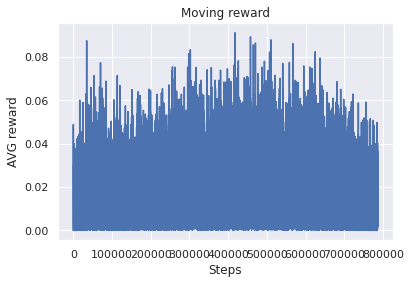

786208it [1:29:57, 145.67it/s]

Average reward for 786200 step : 0.0


KeyboardInterrupt: 

In [46]:
start = time()
counter = 0
reward = []
for user_id, item_id in tqdm.tqdm(generator):
    u_hist = user_hist_buffer.get(user_id)
    u_feature = user_feature_buffer.transform(u_hist, return_names=False)
#     u_feature = np.append(u_feature,[1])
    batch_feature = (i_features[:100]*u_feature).astype('float32')
    action, item, score = bandit.predict(batch_feature)
    feature = batch_feature[action]
    if item==item_id:
        bandit.update(action=action,context=feature,reward=1.0)
        reward.append(1)
    else:
        bandit.update(action=action,context=feature,reward=0.0)
        reward.append(0)
    user_hist_buffer.add(user_id, item_id)
    if counter%batch_metrics==0 and counter!=0:
        clear_output(True)
        plt.plot(moving_average(reward), label='moving reward')
        plt.ylabel('AVG reward')
        plt.xlabel('Steps')
        plt.title('Moving reward')
        plt.show()
        print('Average reward for {0} step : {1}'.format(counter, np.mean(reward[counter - batch_metrics:counter])))
    counter+=1

end = time()
print('Training took : {}'.format((end-start)/60))